<a href="https://colab.research.google.com/github/dar-tau/nlp-experiments/blob/master/introbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

In [ ]:
!pip install transformers datasets
# !pip install simpletransformers

In [ ]:
%cd /content
!mkdir data
%cd /content/data
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import os

import re
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


import datasets
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers.data.processors.squad import SquadV2Processor, squad_convert_examples_to_features

import spacy


In [4]:
device = 'cuda'

def torchTokenize(*args):
  return tokenizer(*args, truncation = True,
                       padding = True, return_tensors = 'pt')

def squad_to_introbert(squad_zipped_example_and_features):
  squad_example, squad_features = squad_zipped_example_and_features
  res = {'start_position': squad_features.start_position, 
         'end_position': squad_features.end_position}
  res.update({'context': squad_example.context_text,
              'question': squad_example.question_text})
  # res.update({k: torch.Tensor(as_dict[k], device = device) for k in ['input_ids', 'attention_mask','token_type_ids'] })
  return res

def dictToDevice(d, device):
  d_ = {}
  for k, v in d.items():
    if isinstance(v, torch.Tensor):
      d_[k] = v.to(device)
    else:
      d_[k] = v
  return d_

In [ ]:
pos_tokenizer = AutoTokenizer.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
pos_model = AutoModelForTokenClassification.from_pretrained("vblagoje/bert-english-uncased-finetuned-pos")
pos_model.to(device)
id2label =  {
    "0": "ADJ",
    "1": "ADP",
    "2": "ADV",
    "3": "AUX",
    "4": "CCONJ",
    "5": "DET",
    "6": "INTJ",
    "7": "NOUN",
    "8": "NUM",
    "9": "PART",
    "10": "PRON",
    "11": "PROPN",
    "12": "PUNCT",
    "13": "SCONJ",
    "14": "SYM",
    "15": "VERB",
    "16": "X"
  }

In [24]:
class IntrobertDataset(Dataset):
  def __init__(self, srcDataset, func, device = device):
    self.ds = srcDataset
    self.func = func
    self.device = device
    self.isModelSet = False

  def setModel(self, model, nLayers, nHeads):
    self.model = model
    self.nLayers = nLayers
    self.nHeads = nHeads
    self.isModelSet = True 

  def __getitem__(self, i):
    assert(self.isModelSet)
    data = self.func(self.ds[i])
    context = data['context']
    start_position = None
    end_position = None
    inputs = None
    questionFunc = None
    question_type = self.choose_question_type()
    use_original = question_type == 0
    if use_original: 
      start_position = data['start_position']
      end_position = data['end_position']
      question = data['question']
    else:
      if question_type == 1:
          chosenLayer = np.random.choice(self.nLayers)
          chosenHead = np.random.choice(self.nHeads)
          question = "what is the most attended word in [att-{}-{}]?".format(chosenLayer, chosenHead)

          def questionFunc(model, attentions):
            res = attentions[chosenLayer][:,chosenHead].sum(dim = -2)[:, 1:].argmax()
            res += 1
            return (res, res)
      else:
          inputs = pos_tokenizer(context, return_tensors = 'pt', truncation = True)
          inputs = dictToDevice(inputs, self.device)
          all_tags = pos_model(**inputs)[0].argmax(-1).view(-1)
          res = np.random.choice(len(all_tags))
          question = "find some token of type [{}] in the text".format(id2label[str(all_tags[res].item())])
          def questionFunc(model, attentions):
            return (res, res)

    inputs = torchTokenize(context, question)
    inputs = dictToDevice(inputs, self.device)

    return {'context': context, 'inputs': inputs, 'start_position' : start_position, 'end_position': end_position,
            'question': question, 'func': questionFunc, 'use_original': use_original,
             'question_type': question_type}

  def choose_question_type(self):
    return np.random.choice(3)

  def __len__(self):
    return len(self.ds)

## Main

In [47]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
tokenizer.add_tokens(["[att-{}-{}]".format(i,j) for i in range(6) for j in range(12)], special_tokens=True)
tokenizer.add_tokens(["[{}]".format(x) for _, x in id2label.items()])

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad", output_attentions = True, 
                                                      return_dict = True)
model.resize_token_embeddings(len(tokenizer))
model.to(device)
optimizer = AdamW(model.parameters(), lr = 3e-6)


In [48]:
if 'dataset' not in globals():
  max_seq_length = 384
  doc_stride = 128
  max_query_length = 64
  total = 10000
  squad_examples = SquadV2Processor().get_train_examples("/content/data")[:total]
  squad_features = squad_convert_examples_to_features(squad_examples, tokenizer = tokenizer, 
                                    max_seq_length = max_seq_length,
                                    max_query_length = max_query_length,
                                    doc_stride = doc_stride, is_training = True, return_dataset = None)

dataset = IntrobertDataset(list(zip(squad_examples, squad_features)), squad_to_introbert)
dataset.setModel("distilbert-base-cased-distilled-squad", 6, 12)

In [ ]:
from collections import defaultdict
start_positions = defaultdict(int)
was_original = []

n_epochs = 10
num_training_steps = total * n_epochs 
num_warmup_steps = total 
losses = []
 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: x/num_training_steps)
# get_linear_schedule_with_warmup(optimizer,num_warmup_steps, num_training_steps)
# torch.optim.lr_scheduler.OneCycleLR(optimizer, 5e-5, total_steps = n_epochs * total,
#                                                 epochs = n_epochs)


from tqdm import tqdm as simple_tqdm
model.train()

for e in range(n_epochs):
  losses.append([])
  t = simple_tqdm(dataset, total = total, leave = True, position = 0)
  acc_sum1 = 0
  acc_sum2 = 0
  i_ = 0
  for i, data in enumerate(t):
    if i >= total:
      break    

    model.eval()
    inputs = data['inputs']
    questionFunc = data['func']
    use_original = data['use_original']
    was_original.append(int(use_original))
    if not use_original:
      outputs = model(**inputs)
    model.train()
    model.zero_grad()
    if use_original:
      start_position = data['start_position']
      end_position = data['end_position']
    else:
      start_position, end_position = questionFunc(model, outputs.attentions)
      # start_positions[start_position.item()] += 1          
    start_position = torch.Tensor([start_position]).to(device).detach().long()
    end_position = torch.Tensor([end_position]).to(device).detach().long()

    outputs = model(**inputs, start_positions = start_position,
                    end_positions = end_position)
    
    loss = outputs.loss

    losses[e].append(loss.item())

    if data['question_type'] == 1:
      acc_sum1 += int((start_position.item() == outputs.start_logits.argmax().item())) 
      acc_sum2 += int((end_position.item() == outputs.end_logits.argmax().item()))
      i_ += 1
      acc1 = acc_sum1/i_
      acc2 = acc_sum2/i_

    t.set_postfix_str("Loss: {:.2f}, Acc1: {:.2f}, Acc2: {:.2f}".format(loss.item(), acc1, acc2))
    loss.backward()
    optimizer.step()
    scheduler.step()

In [84]:
emb = model.get_input_embeddings().cpu()
new_emb = emb(torch.LongTensor(list(tokenizer.get_added_vocab().values())))

In [85]:
from sklearn.manifold import TSNE
tsne = TSNE(metric = 'cosine')
xy_emb = tsne.fit_transform(new_emb.detach().numpy())

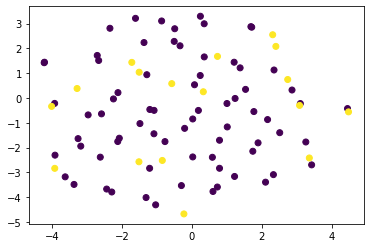

In [88]:
plt.scatter(xy_emb[:,0], xy_emb[:,1], c = ([0]*72) + ([1]*17))